In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import re
import random
import os
from itertools import groupby
from toy_model_helper import *
from datetime import datetime
import pytz

In [2]:
# default parameters
param = {'act_func': 'linear',
         'epoch_n': 1000,
         'save_interval': 500,
         'r1_size': 100,
         's10': 10,
         's11': 1,
         's21': 10,
         's22': 1,
         's32': 5,
         'alpha_1': 0.1,
         'alpha_2': 5,
         'beta_1': 0.1,
         'beta_2': 0.1,
         'gamma_1': 0.01,
         'gamma_2': 0.01,
         'softmax_c': 1,
         'recog_mode': 1,
         'recog_value': 1,
         'in_dir': './data/3x3_short/',
         'out_dir': './results',
         'timestamp': datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H-%M-%S'),
         'ipynb': 'toy_model_kalman_variant_4.ipynb',
         'param_id': 'None',
         'weight_init_seed': 1,
         'timecourse_sharey': False}

In [3]:
param = pd.Series(param)
param

act_func                                       linear
epoch_n                                          1000
save_interval                                     500
r1_size                                           100
s10                                                10
s11                                                 1
s21                                                10
s22                                                 1
s32                                                 5
alpha_1                                           0.1
alpha_2                                             5
beta_1                                            0.1
beta_2                                            0.1
gamma_1                                          0.01
gamma_2                                          0.01
softmax_c                                           1
recog_mode                                          1
recog_value                                         1
in_dir                      

In [4]:
for x in param.index:
    if isinstance(param[x], str):
        exec("{} = '{}'".format(x, param[x]))
    else:
        exec("{} = {}".format(x, param[x]))

# Inputs

In [5]:
I_filenames = glob.glob(os.path.join(in_dir, "*.png"))
I_dict = {}

for i in I_filenames:
    I = cv2.imread(i)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I/255
    
    I_id = re.sub(r".*_(.*)\.png", r"\1", i)
    
    I_dict.update({I_id: I})

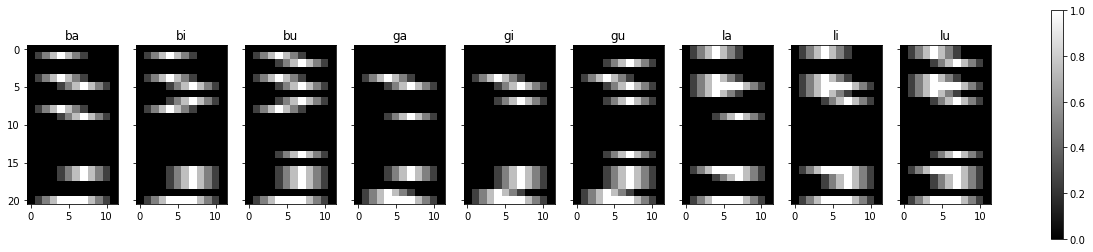

In [6]:
ncols = len(I_dict)
nrows = 1

subplot_y, subplot_x = I.shape
scale = 0.2
subplot_y, subplot_x = tuple(i * scale for i in (subplot_y, subplot_x))

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=True, sharey=True)

for k, ax in zip(I_dict.keys(), axes.flatten()):
    im = ax.imshow(I_dict[k], cmap="gray")
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Parameters

In [7]:
epoch_max = max(range(epoch_n))
save_epochs = [x for x in range(epoch_n) if x == 0 or x % save_interval == save_interval-1]

I_size = I.shape[0]
L_size = len(I_dict)
r2_size = L_size

In [8]:
model = Model(I_size, r1_size, r2_size, L_size, seed=weight_init_seed)

model.s10 = s10
model.s11 = s11
model.s21 = s21
model.s22 = s22
model.s32 = s32

model.alpha_1 = alpha_1
model.alpha_2 = alpha_2
model.beta_1 = beta_1
model.beta_2 = beta_2
model.gamma_1 = gamma_1
model.gamma_2 = gamma_2

# Training & Testing

In [9]:
%%capture

all_weights = {"epoch": [], "U1": [], "U2": [], "V1": [], "V2": []}

for epoch in range(epoch_n):
    np.random.seed(epoch)
    I_order = random.sample(list(I_dict.keys()), len(I_dict))
    
    for k in I_order:
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]
        df = model.apply_input(k, I_dict[k], L, training=True, af=act_func)
    
    if epoch in save_epochs:
        all_weights["epoch"].append(epoch)
        all_weights["U1"].append(model.U1)
        all_weights["U2"].append(model.U2)
        all_weights["V1"].append(model.V1)
        all_weights["V2"].append(model.V2)
        
all_weights_df = pd.DataFrame.from_dict(all_weights)

In [10]:
%%capture

output_train_df = pd.DataFrame()
output_test_df = pd.DataFrame()

for epoch in save_epochs:
    weights_df = all_weights_df.groupby("epoch").get_group(epoch).squeeze()
    model.U1 = weights_df.U1
    model.U2 = weights_df.U2
    model.V1 = weights_df.V1
    model.V2 = weights_df.V2
    
    np.random.seed(epoch+1)
    I_order = random.sample(list(I_dict.keys()), len(I_dict))
    
    for k in I_dict:
        df = model.apply_input(k, I_dict[k], np.zeros(L_size), training=False, af=act_func)
        df["epoch"] = epoch
        output_test_df = output_test_df.append(df, ignore_index=True)
    
    for k in I_order:
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]
        
        df = model.apply_input(k, I_dict[k], L, training=True, af=act_func)
        df["epoch"] = epoch
        output_train_df = output_train_df.append(df, ignore_index=True)

# Timecourse

## First Epoch

### Training

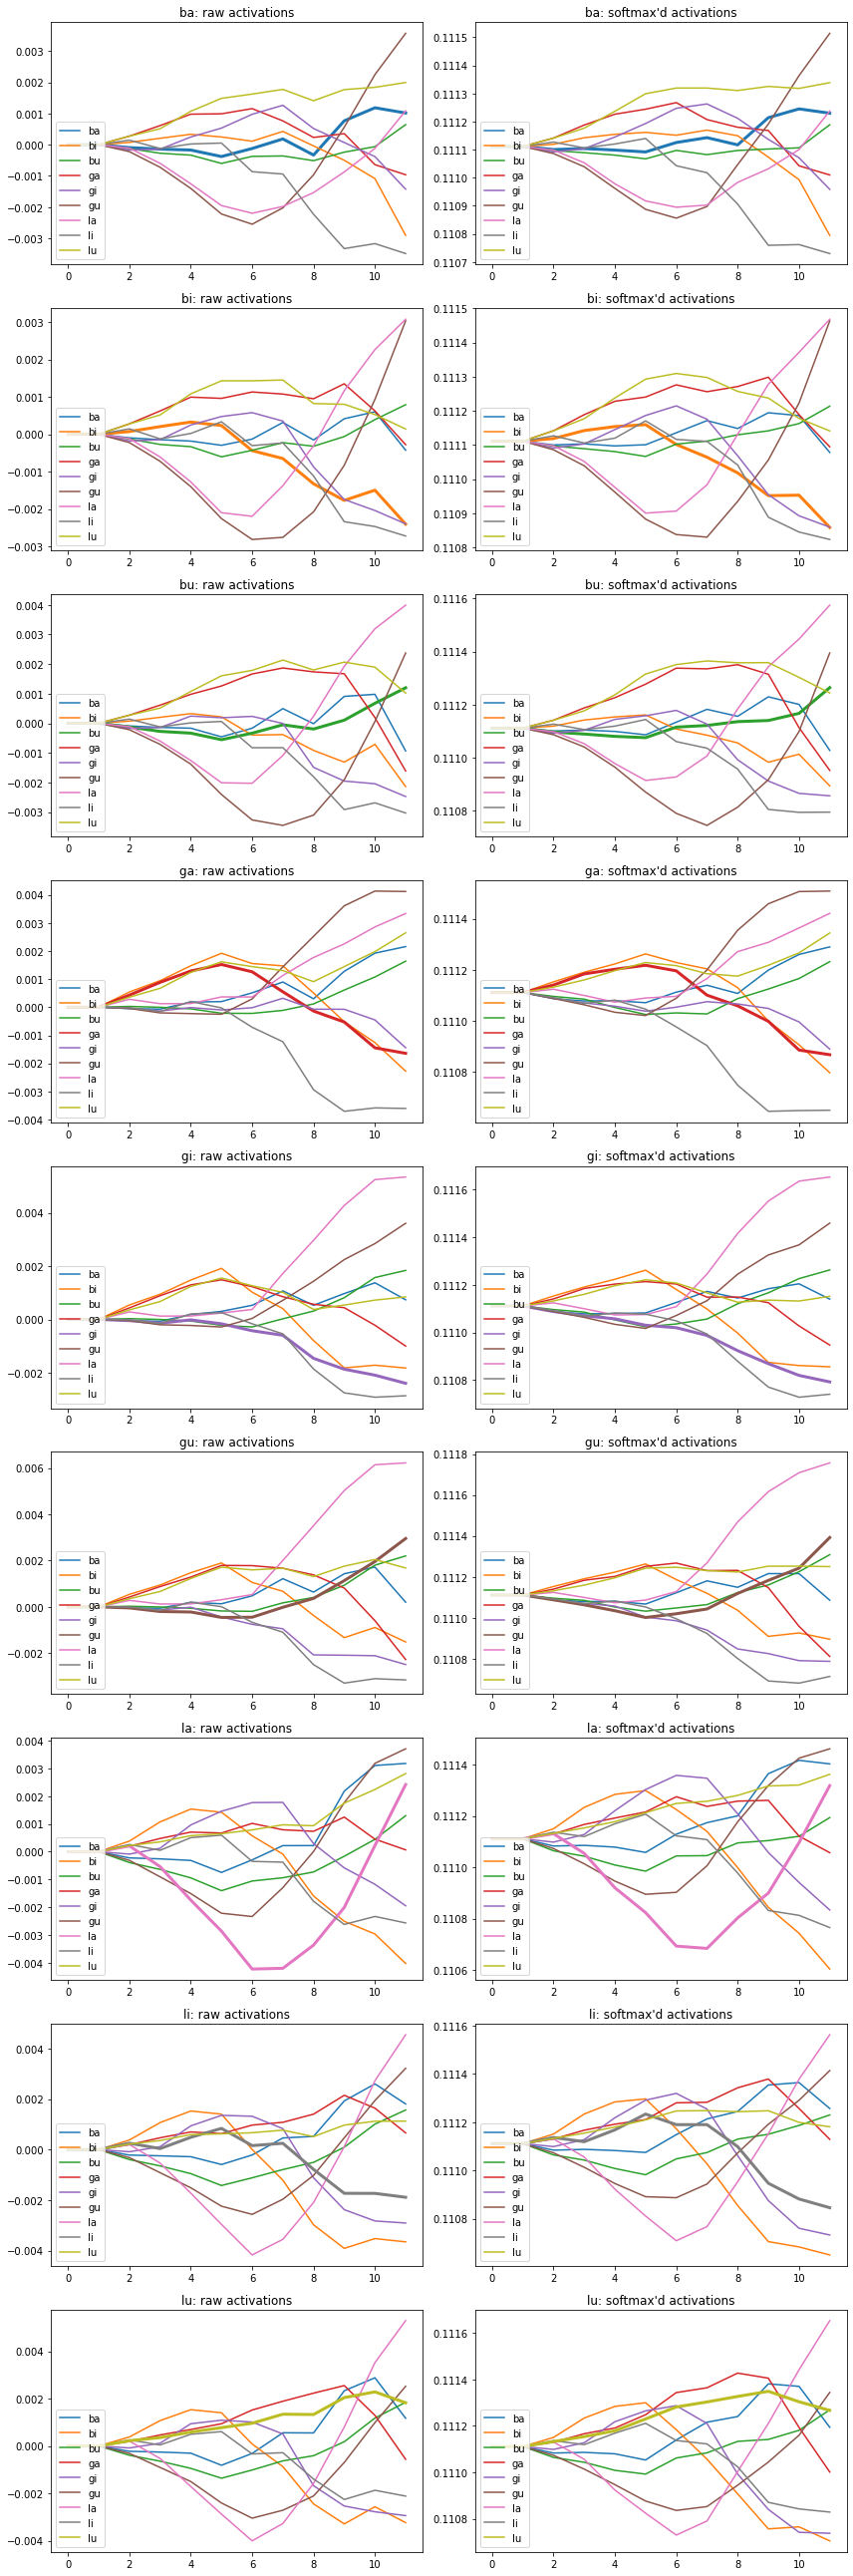

In [11]:
raw_vs_softmax_plots(df=output_train_df.groupby("epoch").get_group(0),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat", c=softmax_c, sharey=timecourse_sharey)

### Testing

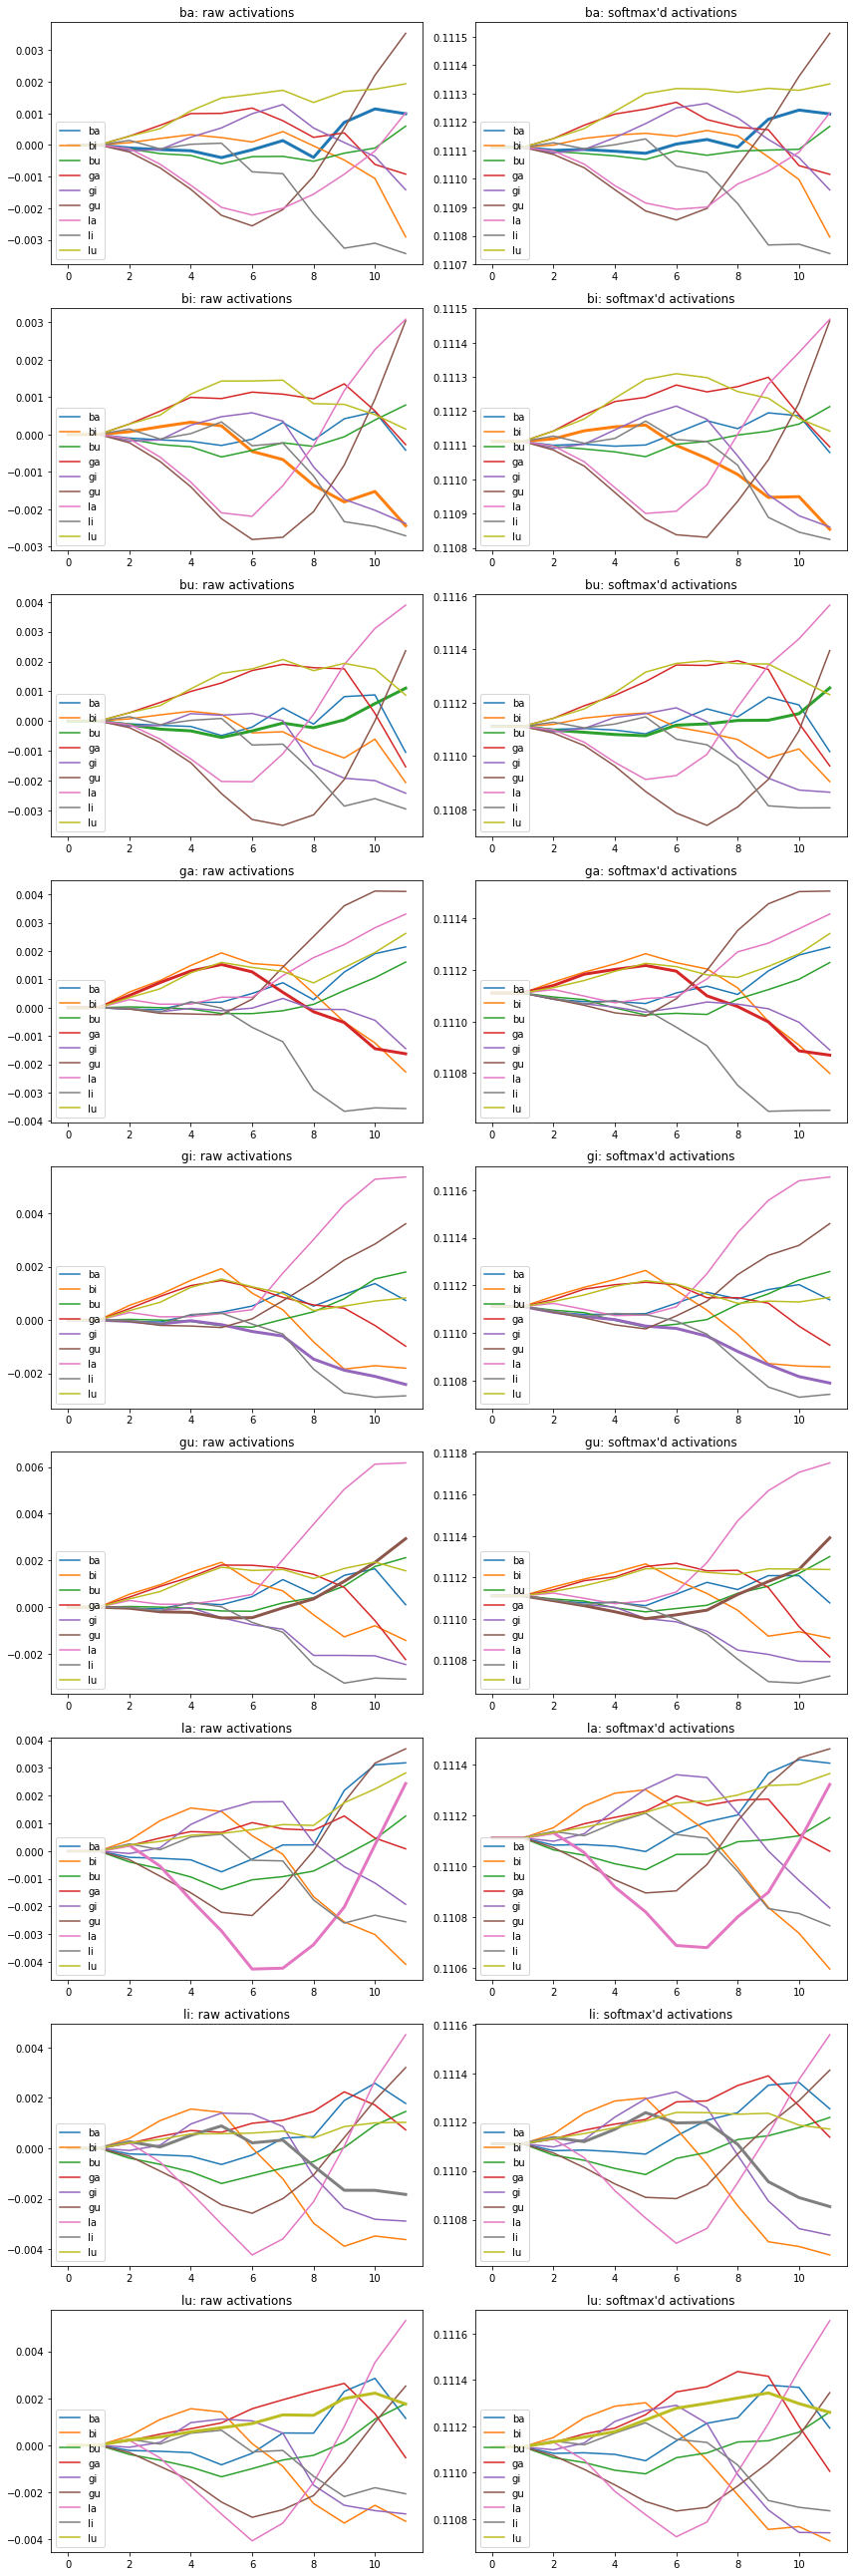

In [12]:
raw_vs_softmax_plots(df=output_test_df.groupby("epoch").get_group(0),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat", c=softmax_c, sharey=timecourse_sharey)

## Last Epoch

### Training

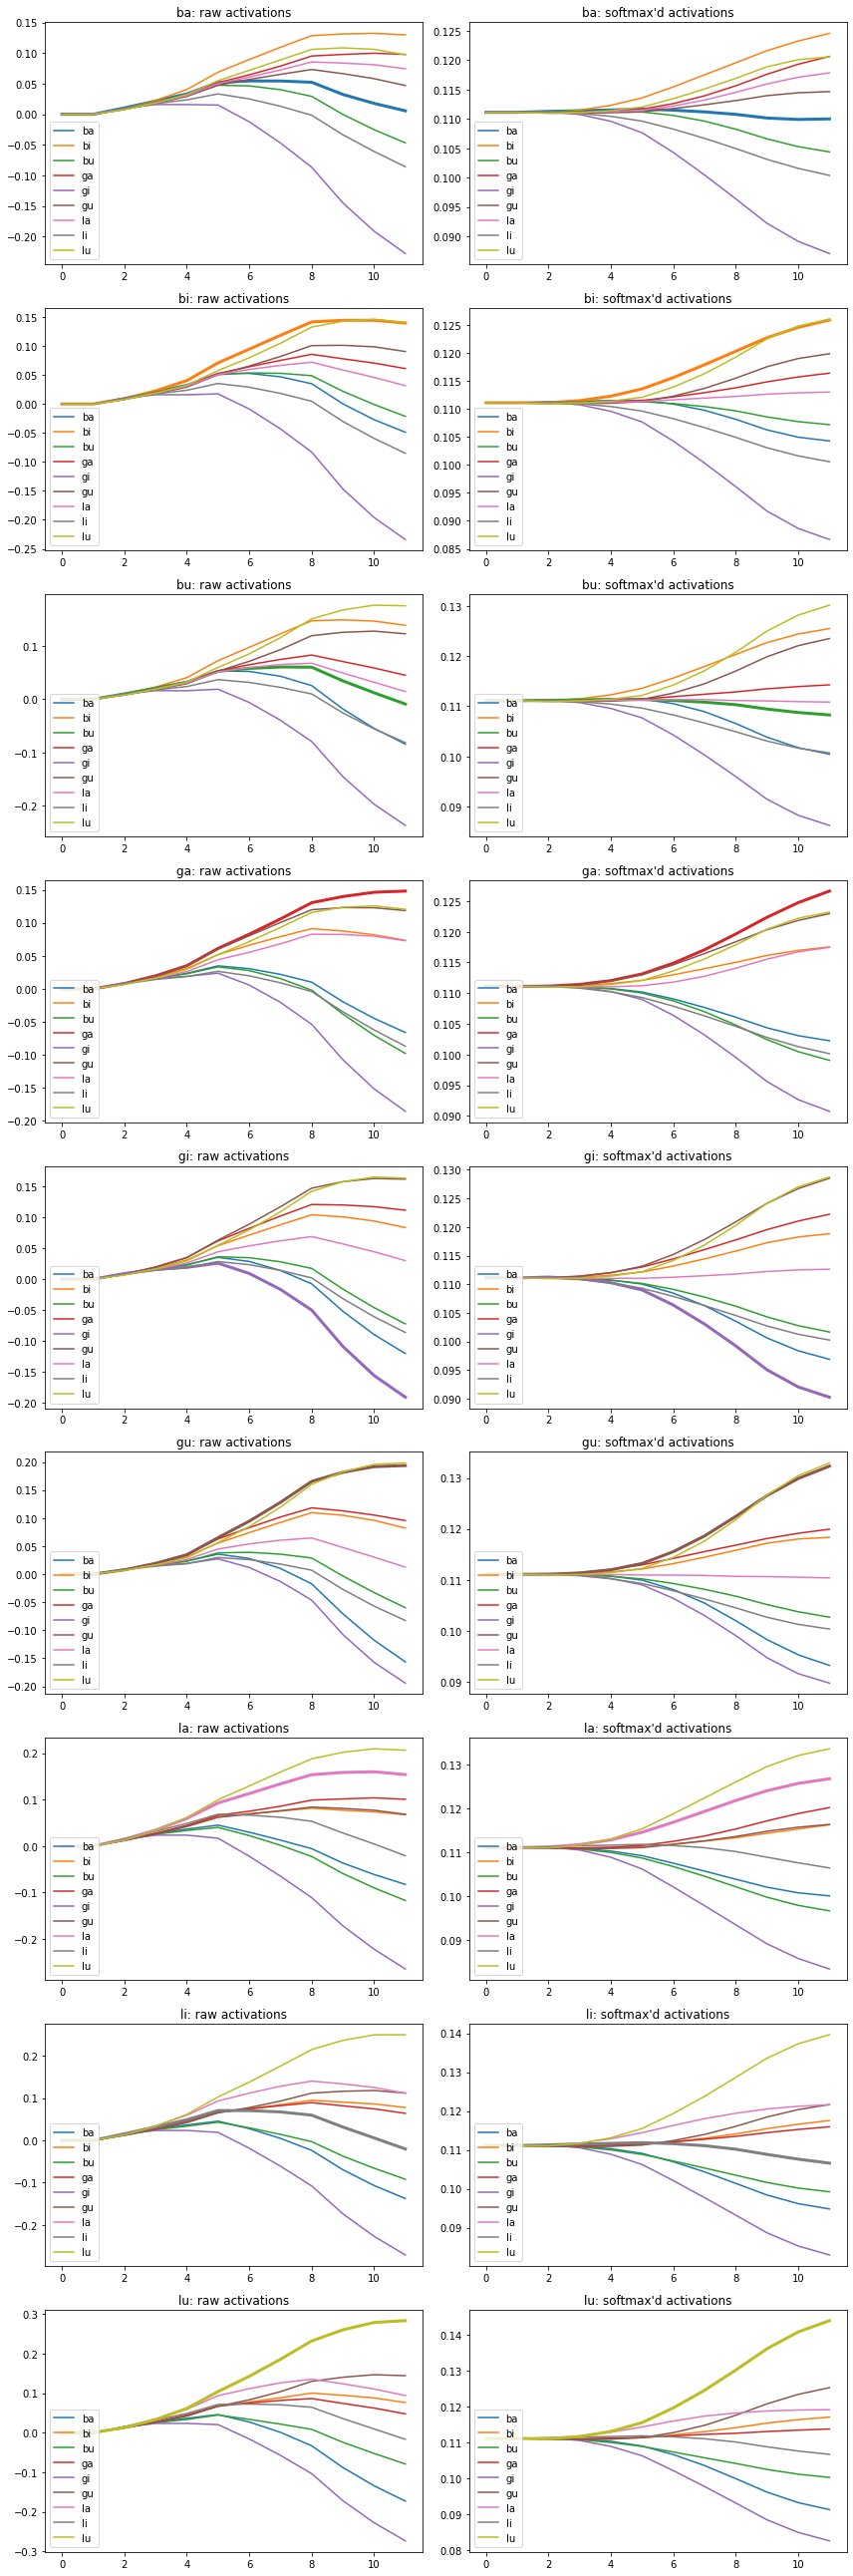

In [13]:
raw_vs_softmax_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat", c=softmax_c, sharey=timecourse_sharey)

### Testing

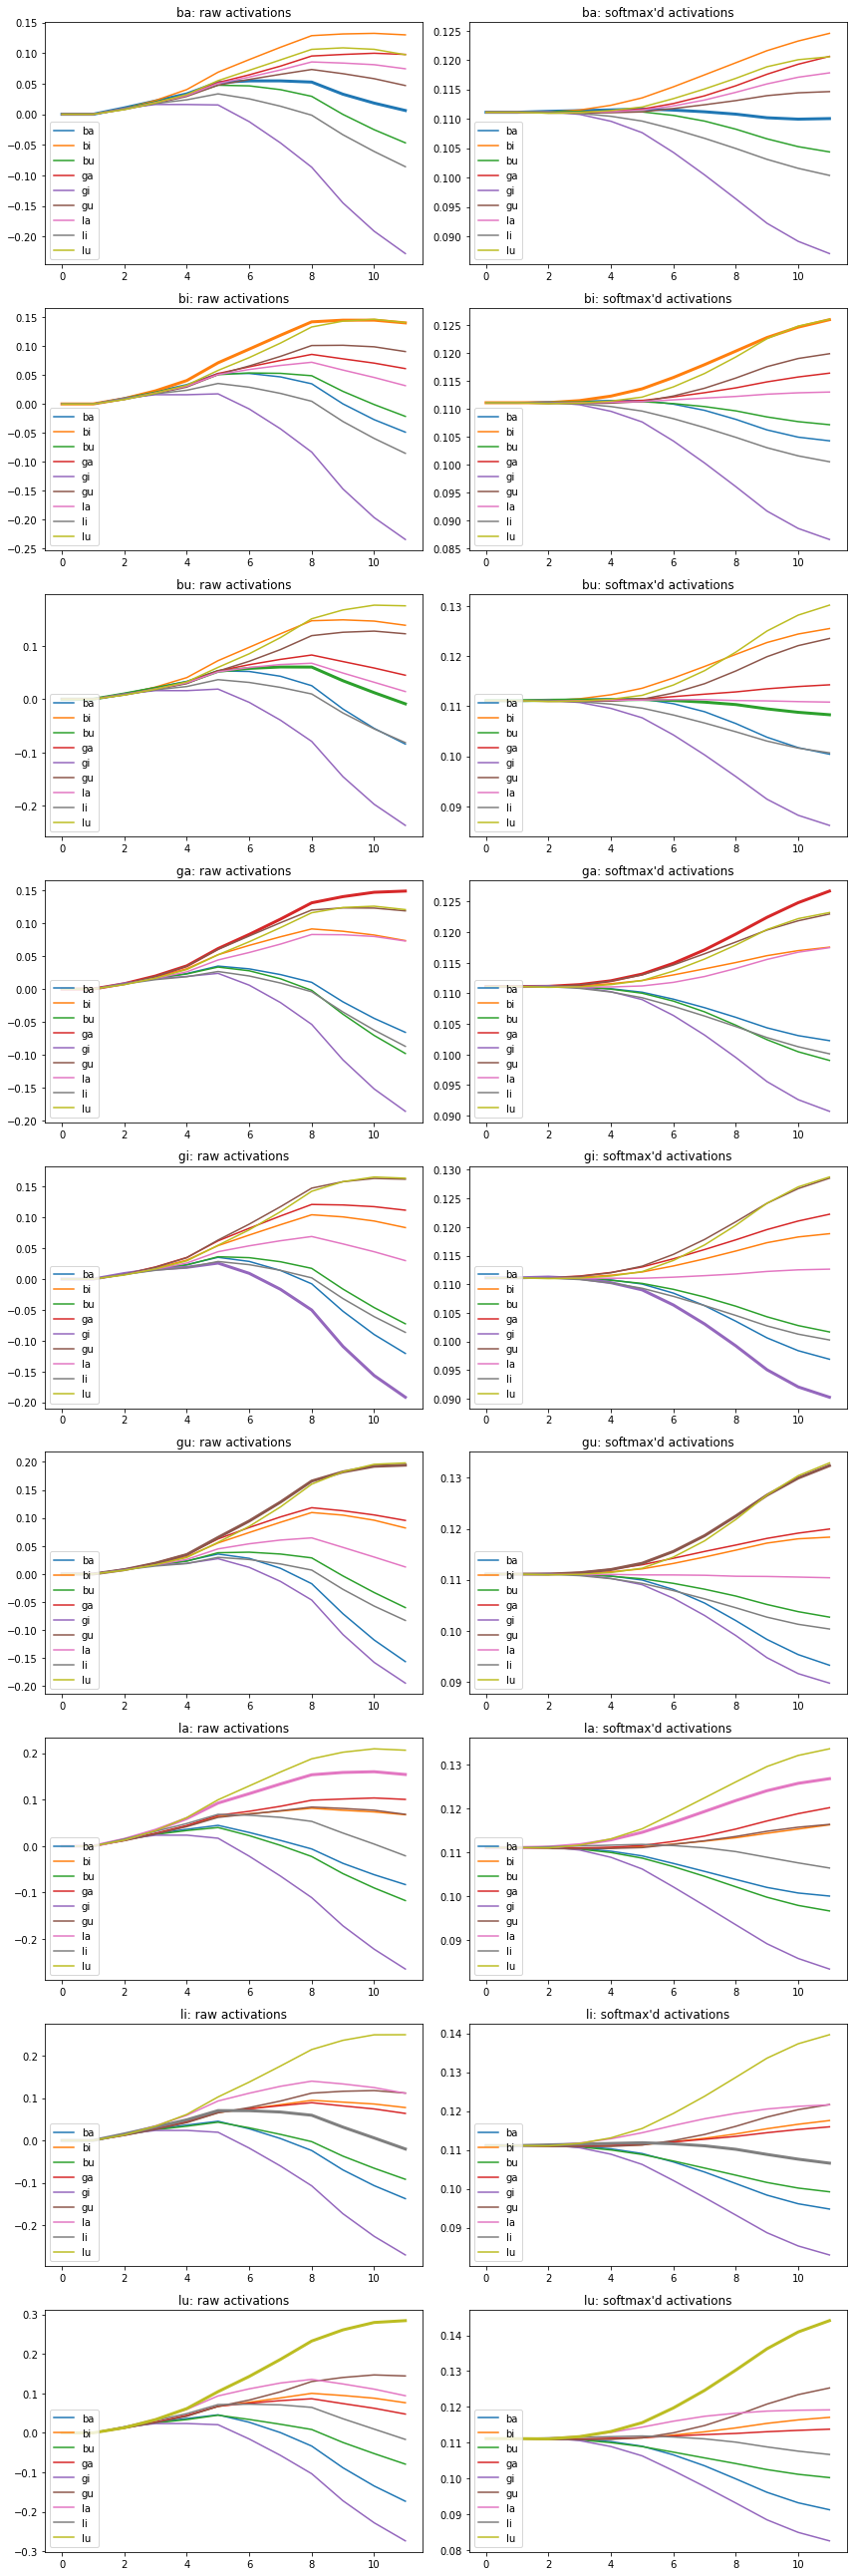

In [14]:
raw_vs_softmax_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat", c=softmax_c, sharey=timecourse_sharey)

# Input Reconstruction

In [15]:
ncols = len(I_dict)
nrows = 1
subplot_yx = I.shape
scale = 0.2

## Actual Inputs

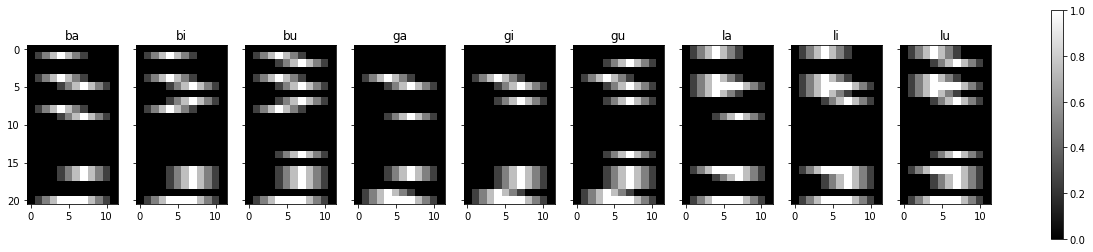

In [16]:
recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="I")

## Reconstruction Based on r1_hat

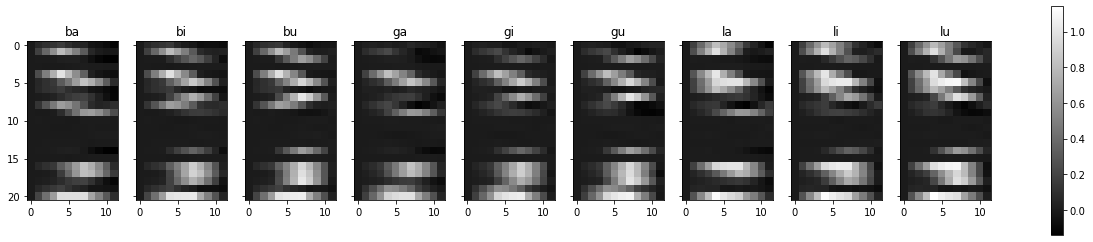

In [17]:
output_test_df["r1_hat_recon"] = output_test_df.apply(lambda x: model.U1 @ x.r1_hat, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_hat_recon")

## Reconstruction Based on r1_bar

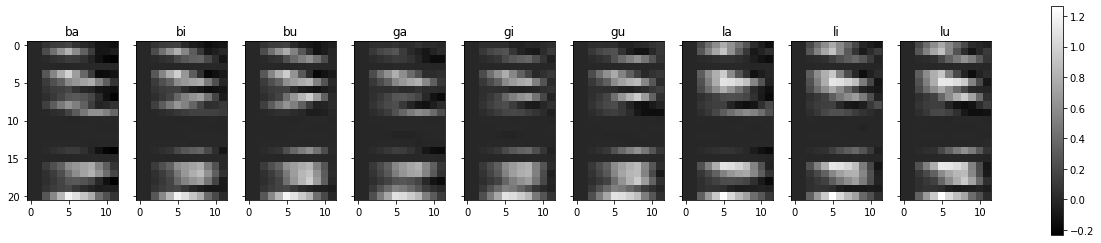

In [18]:
output_test_df["r1_bar_recon"] = output_test_df.apply(lambda x: model.U1 @ x.r1_bar, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_bar_recon")

## Differences of Reconstruction of r1_bar and r1_hat

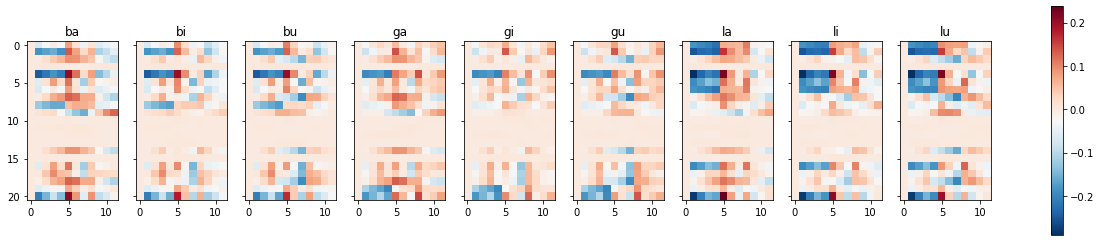

In [19]:
output_test_df["r1_recon_diff"] = output_test_df.apply(lambda x: x.r1_bar_recon - x.r1_hat_recon, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_recon_diff", cmap="RdBu_r")

# Accuracy

## Training

In [20]:
output_train_df["softmaxd_r2_hat"] = output_train_df.apply(lambda x: softmax(x.r2_hat, c=softmax_c), axis=1)

train_recog_df = output_train_df.groupby(["epoch", "label"]).softmaxd_r2_hat.apply(lambda x: recog(x, mode=recog_mode, value=recog_value)).rename("recog_node").to_frame()
output_train_df = pd.merge(output_train_df, train_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_train_df["label_node"] = output_train_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_train_df["accuracy"] = output_train_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

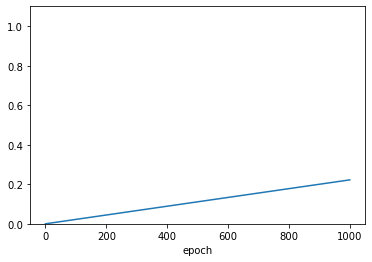

In [21]:
output_train_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

## Testing

In [22]:
output_test_df["softmaxd_r2_hat"] = output_test_df.apply(lambda x: softmax(x.r2_hat, c=softmax_c), axis=1)

test_recog_df = output_test_df.groupby(["epoch", "label"]).softmaxd_r2_hat.apply(lambda x: recog(x, mode=recog_mode, value=recog_value)).rename("recog_node").to_frame()
output_test_df = pd.merge(output_test_df, test_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_test_df["label_node"] = output_test_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_test_df["accuracy"] = output_test_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

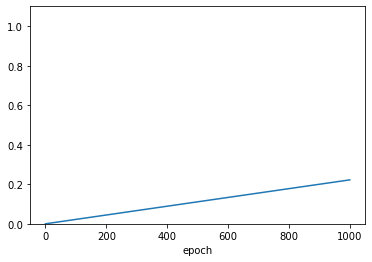

In [23]:
output_test_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

# Weights

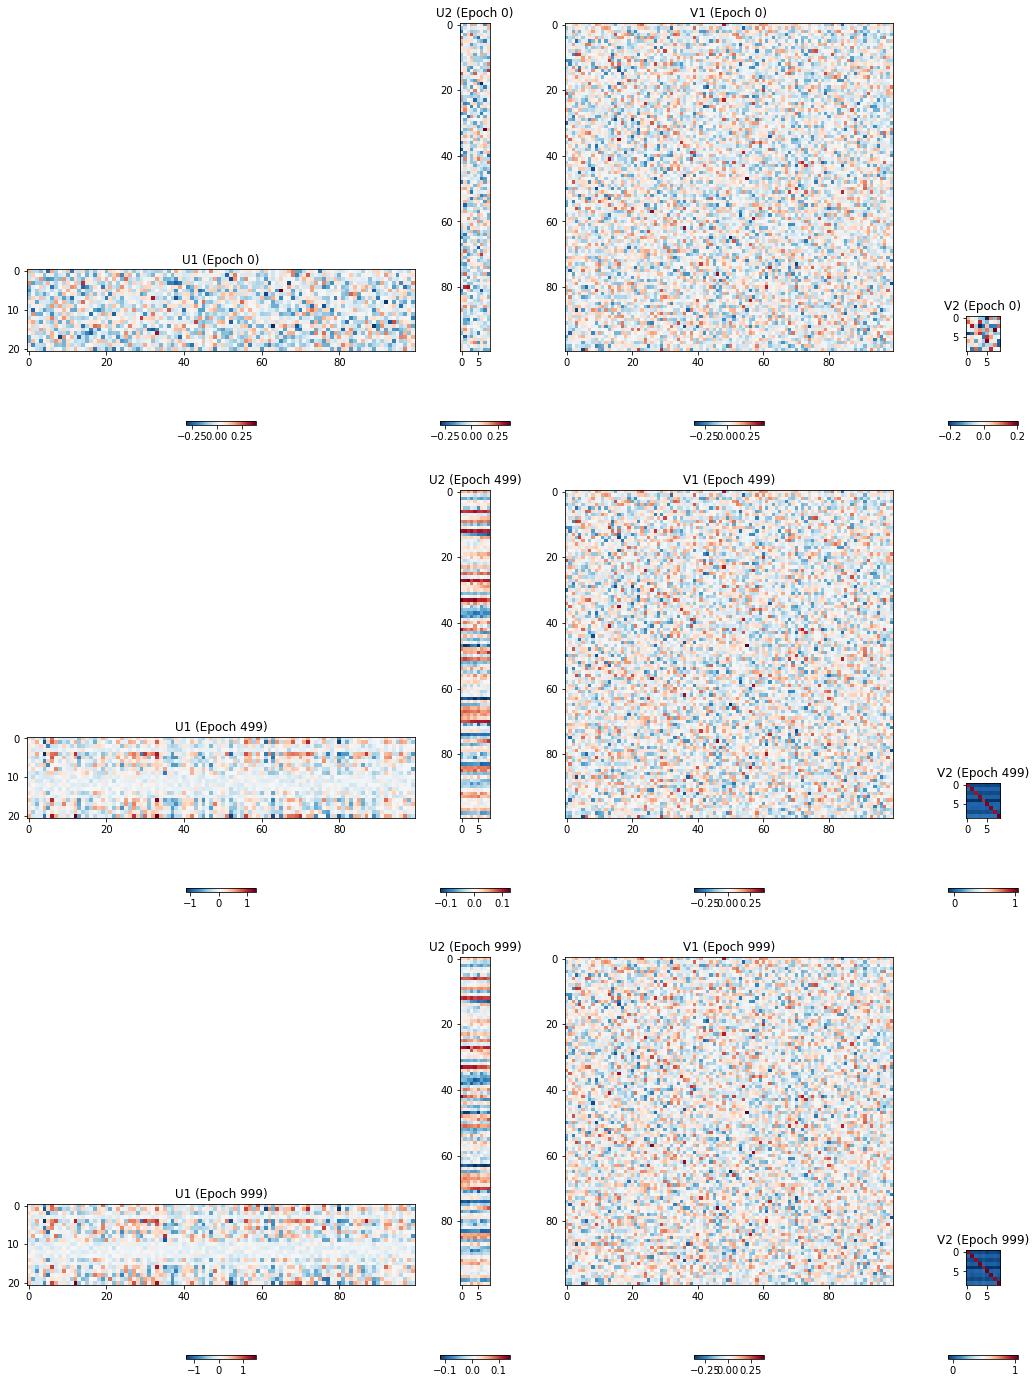

In [24]:
# subplots settings
ncols = 4
nrows = len(all_weights_df.index)

weight_shape_list = [model.U1.shape, model.U2.shape, model.V1.shape, model.V2.shape]

subplot_x = sum([x[1] for x in weight_shape_list]) / 15
subplot_y = max([x[0] for x in weight_shape_list]) / 15
min_x = min([x[1] for x in weight_shape_list]) 

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x, subplot_y*nrows),
                         gridspec_kw={'width_ratios': [x[1] for x in weight_shape_list]})

cmap = "RdBu_r"

for x in range(axes.shape[0]):
    im_0 = axes[x, 0].imshow(all_weights_df.U1[x], cmap=cmap)
    im_1 = axes[x, 1].imshow(all_weights_df.U2[x], cmap=cmap)
    im_2 = axes[x, 2].imshow(all_weights_df.V1[x], cmap=cmap)
    im_3 = axes[x, 3].imshow(all_weights_df.V2[x], cmap=cmap)
    
    axes[x, 0].set_title("U1 (Epoch {})".format(all_weights_df.epoch[x]))
    axes[x, 1].set_title("U2 (Epoch {})".format(all_weights_df.epoch[x]))
    axes[x, 2].set_title("V1 (Epoch {})".format(all_weights_df.epoch[x]))
    axes[x, 3].set_title("V2 (Epoch {})".format(all_weights_df.epoch[x]))
    
    fig.colorbar(im_0, ax=axes[x, 0], orientation="horizontal", shrink=2*min_x/model.U1.shape[1]);
    fig.colorbar(im_1, ax=axes[x, 1], orientation="horizontal", shrink=2*min_x/model.U2.shape[1]);
    fig.colorbar(im_2, ax=axes[x, 2], orientation="horizontal", shrink=2*min_x/model.V1.shape[1]);
    fig.colorbar(im_3, ax=axes[x, 3], orientation="horizontal", shrink=2*min_x/model.V2.shape[1]);

plt.tight_layout()

# Output

In [25]:
import pickle
output_dict = {"param": param,
               "output_test_df": output_test_df,
               "output_train_df": output_train_df,
               "all_weights_df": all_weights_df}

output_pkl = "{}_{}_{}_results.pkl".format(timestamp, param_id, re.sub("\.ipynb$", "", ipynb))
output_pkl_path = os.path.join(out_dir, output_pkl)

pickle.dump(output_dict, open(output_pkl_path, "wb"))